In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from IPython.display import display
from datetime import datetime as dt 
%matplotlib inline

# Implementing the change detection model in python

Using the CuSum Technique to detect changes in data. The main questions we wish to answer is: __Has the mean ($\mu$) of the observed distribution gone beyond a critical level ($S_t ≥ T$)?__

Lets begin by gathering some daily stock price data, for a few stocks. Given the current state of the economy in May of 2022 lets go all the way back to 1999, so that we can capture all of the major economic events in the 21st century. Namely, the 'Dot com' bubble of 2001, the global financial crisis of 2008. We can refer to the current state as "The crime of the century" which includes the reverse repo crisis of 2019, the covid crash, and the current stage. Since this stage is essentially the preceding stages to a larger market event which is due in the future, we should note that changes might not be fully registered yet. 

Lets also define some dates of particular interest, those that are listed above. 

In [75]:
stock_names = "^gspc ^ixic ^dji ^rut ^tnx ^tyx aapl tsla msft wmt amzn cvx xom jpm c bac gs".upper().split(' ')
stock_map = {'^GSPC':'SPY', '^IXIC':'QQQ', '^DJI': 'DIA', '^RUT':'IWM', '^TNX':'TLT', '^TYX':'TBT'}
stocks = [x[1].lower() for x in stock_map.items()]
times_of_interest = {
    'dotCom': {'preceding': ['1994-12-31', '1999-12-31'], 'crash': ['2000-01-01', '2002-12-31']},
    'globalFinancialCrisis': {'preceding': ['2003-01-01','2007-07-31'], 'crash': ['2007-08-01', '2008-12-31']},
    'postCovid': {'preceding': ['2017-12-31', '2022-05-06'], 'crash': ['TBD']}
    }


dotCom = [pd.to_datetime(dt.strptime(x, '%Y-%m-%d')) for x in times_of_interest['dotCom']['preceding']]
dotComCrash = [pd.to_datetime(dt.strptime(x, '%Y-%m-%d')) for x in times_of_interest['dotCom']['crash']]
GFC =  [pd.to_datetime(dt.strptime(x, '%Y-%m-%d')) for x in times_of_interest['globalFinancialCrisis']['preceding']]
GFC_crash =  [pd.to_datetime(dt.strptime(x, '%Y-%m-%d')) for x in times_of_interest['globalFinancialCrisis']['crash']]
COC =  [pd.to_datetime(dt.strptime(x, '%Y-%m-%d')) for x in times_of_interest['postCovid']['preceding']]


In [76]:
stocks = []
for i in stock_names:
    if i.upper() in stock_map.keys():
        stocks.append(stock_map.get(i))
    else:
        stocks.append(i)
print(stocks)

['SPY', 'QQQ', 'DIA', 'IWM', 'TLT', 'TBT', 'AAPL', 'TSLA', 'MSFT', 'WMT', 'AMZN', 'CVX', 'XOM', 'JPM', 'C', 'BAC', 'GS']


In [77]:
def get_price_data(stocks, download = False):
    stocks = [x.upper() for x in stocks]
    if download != False: 
        import yfinance as yf 
        today = dt.today().strftime('%Y-%m-%d')
        stock_price = yf.download(stocks, start='1994-12-31', end=today)
        stock_price.columns.names =['Metric', 'Stock_name']
        stock_price.head()
        stock_price.to_csv('stock_prices.csv')
        return stock_price
    else: 
        sp = pd.read_csv('stock_prices.csv', header=[0,1])
        sp.set_index(sp.columns[0], inplace= True)
        sp.index.name = 'Date'
        sp.columns.names =['Metric', 'Stock_name']
        return  sp.iloc[1:, :]
# store stock price in data frame so that you dont have to continuously load the same file in iteration
sp = get_price_data(stock_names, False)
sp.rename(columns = stock_map, level =1, inplace=True)
# get ohlcv for a prticular symbol 
def add_stock_price(stock, sp = sp):
    out = sp.xs(key = stock.upper(), axis = 1, level = 'Stock_name', drop_level=True)
    out.columns.names = ['']
    out.columns = out.columns.get_level_values(0)
    return out


In [78]:
stock_data = {x: add_stock_price(x, sp) for x in stocks}
print('stocks: ',list(stock_data.keys()))
display(stock_data['TSLA'].dropna())

stocks:  ['SPY', 'QQQ', 'DIA', 'IWM', 'TLT', 'TBT', 'AAPL', 'TSLA', 'MSFT', 'WMT', 'AMZN', 'CVX', 'XOM', 'JPM', 'C', 'BAC', 'GS']


,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2010-06-29,4.778000,4.778000,5.000000,3.508000,3.800000,93831500.0
2010-06-30,4.766000,4.766000,6.084000,4.660000,5.158000,85935500.0
2010-07-01,4.392000,4.392000,5.184000,4.054000,5.000000,41094000.0
2010-07-02,3.840000,3.840000,4.620000,3.742000,4.600000,25699000.0
2010-07-06,3.222000,3.222000,4.000000,3.166000,4.000000,34334500.0
...,...,...,...,...,...,...
2022-05-02,902.940002,902.940002,906.359985,848.030029,860.770020,25260500.0
2022-05-03,909.250000,909.250000,924.080017,888.590027,903.179993,21236500.0
2022-05-04,952.619995,952.619995,955.500000,885.280029,903.940002,27214600.0


### Suppose we have the following: 

$$x_i = \text{Observed value at time } t$$

$$\mu = \text{Mean of x if no change}$$

$$S_t = max(0, S_{t-1} + (x_t - \mu - C))$$

$$S_t ≥ T$$

Where T is a defined threshold and $S_t$ is the maximum value between 0 and the sum of the previous observed value at time $t -1$

Thus, we need to define a threshold $T$ and a critical level $C$, we can check for an **Increase** in deviations from the mean. 

To check for an increase, $(x_t - \mu - C)$; for a decrease $(\mu - x_t - C)$, and both ways can be checked with $(|x_t - \mu| - C)$
The algorithim will go as follows: 

1. Calculate the mean of the daily averages
2. Calculate $x_t - \mu - C$
3. Calculate $max(0, S_{t-1} + (x_t - \mu - C))$ (Depending on which direction you wish to look for a change.)

Now, lets implement the change detection model, without assuming too much about the data. We need to account for the index of the data frame, as this will help visualize when the change happens in the end. 

In [79]:
def chgDetector(d, sensitivity = 1, threshold = 1, direction= 'both'):
    from pandas import DataFrame
    import numpy as np 
    """ X = dataframe perferably a 1d series, or array, datetime index is allowed. 
    Input aggregated data for better result. The algorithim will look 
    for changes given a sensitivity and threshold level. """

    x_i = d.to_numpy()

    mu = np.mean(x_i)

    if direction.lower() == 'increase':
        x_mu_c = (x_i - mu - sensitivity)
    if direction.lower() == 'decrease':
        x_mu_c = (mu - x_i - sensitivity)
    if direction.lower() == 'both':
        x_mu_c = abs(x_i - mu) - sensitivity
    x_mu_c[0,] = 0
    
    s_t = np.zeros(x_mu_c.shape)

    for i in range(1, x_mu_c.shape[0]):
        s_t[i] = max(0, (s_t[(i-1)] + x_mu_c[i]))
    
    t = 1.0*(s_t > threshold)
    out = DataFrame(np.array([x_mu_c, s_t, t]).T,columns= ['X_MU_C', 'S_T', 'Threshold_trigger'], index=d.index).round(4)
    hits = len(out[out['Threshold_trigger']==1])
    return  hits, out

### Things to keep in mind about paramaters $C$ & $T$

1. The larger the value for $C$, the harder it is for $S_t$ to get large; thus the model will be __Less__ sensitive to achieve. 
2. The smaller the value for $C$, the *easier* it is for $S_t$ to get large, thus the model will be __more__ sensitive to sudden changes. 

Thus its important for us to find an *optimal* parameter for $C$, where the change is not so easily or difficult to be detected. In other words we want the change to be detected no more then $M$ times, and no less than $N$ times. Lets first have a sanity check, and _manually_ test for different values of $C$:

Length of X: 6859
Length of List of C parameters:  3
Sensitivity = 160,000,000	 Trigger Count =  2238
Sensitivity = 320,000,000	 Trigger Count =  2130
Sensitivity = 480,000,000	 Trigger Count =  1253


,X_MU_C,S_T,Threshold_trigger
Date,,,
1995-02-09,0.000000e+00,0.0,0.0
1995-02-10,-1.604746e+09,0.0,0.0
1995-02-13,-1.604389e+09,0.0,0.0
1995-02-14,-1.602684e+09,0.0,0.0
1995-02-15,-1.600206e+09,0.0,0.0


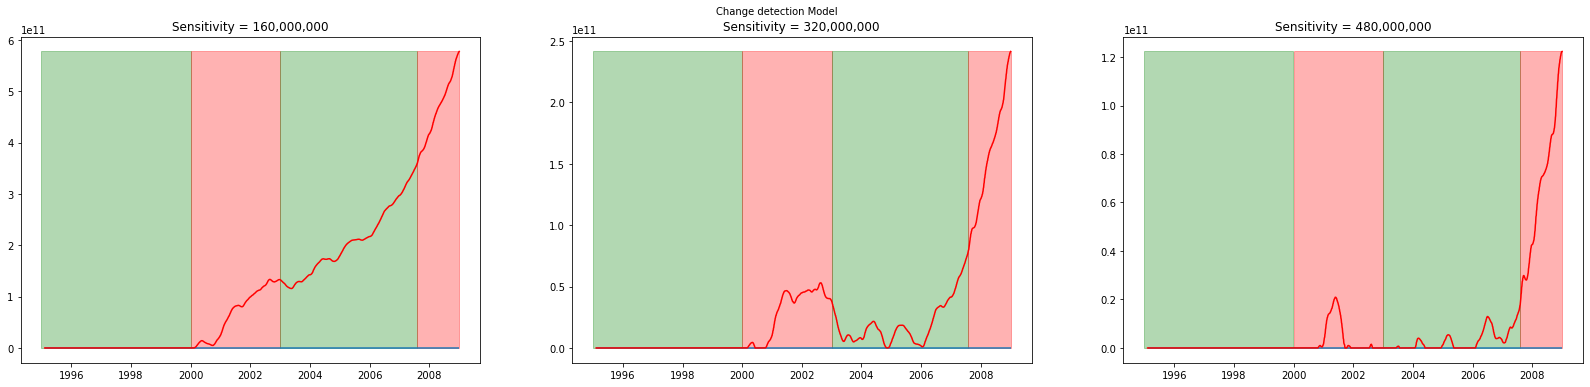

In [180]:
X = stock_data['QQQ']['Volume'].rolling(28).mean().dropna()
print('Length of X:', len(X))

check_C = np.array([1, 2, 3]) * 16e7
print('Length of List of C parameters: ', len(check_C))
thresh = 15e4

cuSum_model_list = []
for x in check_C.tolist():
    count, cuSum_model = chgDetector(X[:'2008-12-31'], sensitivity=x, threshold=thresh, direction='increase')
    cuSum_model_list.append((x, cuSum_model))
    print(f'Sensitivity = {x:,.0f}\t','Trigger Count = ', count)


fig, axs = plt.subplots(1,len(check_C), figsize = (28,6))
plt.subplots_adjust(hspace= .5)
fig.suptitle("Change detection Model", fontsize = 10, y= .95)
for model, ax in zip(cuSum_model_list, axs.ravel()):
    data = model[1]
    ind = pd.DatetimeIndex(data.index)
    ax.plot(ind, data['S_T'], color = 'red')
    ax.hlines(thresh, ind.min(), ind.max())
    ax.fill_between(dotCom, data['S_T'].max(), color = 'green', alpha = .3)
    ax.fill_between(dotComCrash, data['S_T'].max(), color = 'red', alpha = .3)
    ax.fill_between(GFC, data['S_T'].max(), color = 'green', alpha = .3)
    ax.fill_between(GFC_crash, data['S_T'].max(), color = 'red', alpha = .3)
    #ax.fill_between(COC, data['S_T'].max(), color = 'gray', alpha = .3)

    ax.set_title(f'Sensitivity = {model[0]:,.0f}')
display(cuSum_model.head())

> Further, the results of the Change detection Model can be visualized as such: 

In [206]:
def normalize_vector(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def cDmodel_plot(d, check_C, thresh, column = 'Volume', dir = 'both', scale = True):
    if scale == True:
        X = normalize_vector(d[column])
    else: 
        X = d[column]
    cuSum_model_list = []
    for x in check_C.tolist():
        count, cuSum_model = chgDetector(X, sensitivity=x, threshold=thresh, direction=dir)
        cuSum_model_list.append((x, cuSum_model))
        print(f'Sensitivity = {x:,.0f}\t','Trigger Count = ', count)

    fig, axs = plt.subplots(1,len(check_C)+1, figsize = (28,6))
    plt.subplots_adjust(hspace= .5)
    fig.suptitle("Change detection Model", fontsize = 10, y= .95)
    sp = axs.ravel()[0]
    sp.plot(pd.DatetimeIndex(d.index), d['Close'], color = 'black')
    sp.set_ylim(d['Close'].min(), d['Close'].max())
    sp.set_title('Stock Price')
    from random import randint
    n = 10
    color = ['#%06X' % randint(0, 0xFFFFFF) for x in range(n)]

    for model, ax in zip(cuSum_model_list, axs.ravel()[1:]):
        fill_color = color[randint(0, n)]
        data = model[1]
        ind = pd.DatetimeIndex(data.index)
        ax.plot(ind, data['S_T'], color = 'black')
        ax.hlines(thresh, ind.min(), ind.max())
        ax.fill_between(dotCom, data['S_T'].max(), color = 'green', alpha = .1)
        ax.fill_between(dotComCrash, data['S_T'].max(), color = 'red', alpha = .1)
        ax.fill_between(GFC, data['S_T'].max(), color = 'green', alpha = .1)
        ax.fill_between(GFC_crash, data['S_T'].max(), color = 'red', alpha = .1)
        ax.fill_between(COC, data['S_T'].max(), color = 'gray', alpha = .1)
        ax.set_xlim(ind.min(), ind.max())
        ax.set_ylim(data['S_T'].min(), data['S_T'].max())
        ax.vlines(data[data['S_T']> thresh].index,data['S_T'].min(), data['S_T'].max(), color = fill_color, alpha = .5, linewidth= .5)
        ax.set_title(f'Sensitivity = {model[0]:,.4f}')
        sp.vlines(data[data['S_T']> thresh].index,d['Close'].min(), d['Close'].max(), color = fill_color, alpha = .5, linewidth= .5)
  

We want to optimize the function to detect the change in the green regions, perferably right before the red regions start

Sensitivity = 115,787,126	 Trigger Count =  853
Sensitivity = 278,754,166	 Trigger Count =  428
Sensitivity = 313,067,738	 Trigger Count =  137


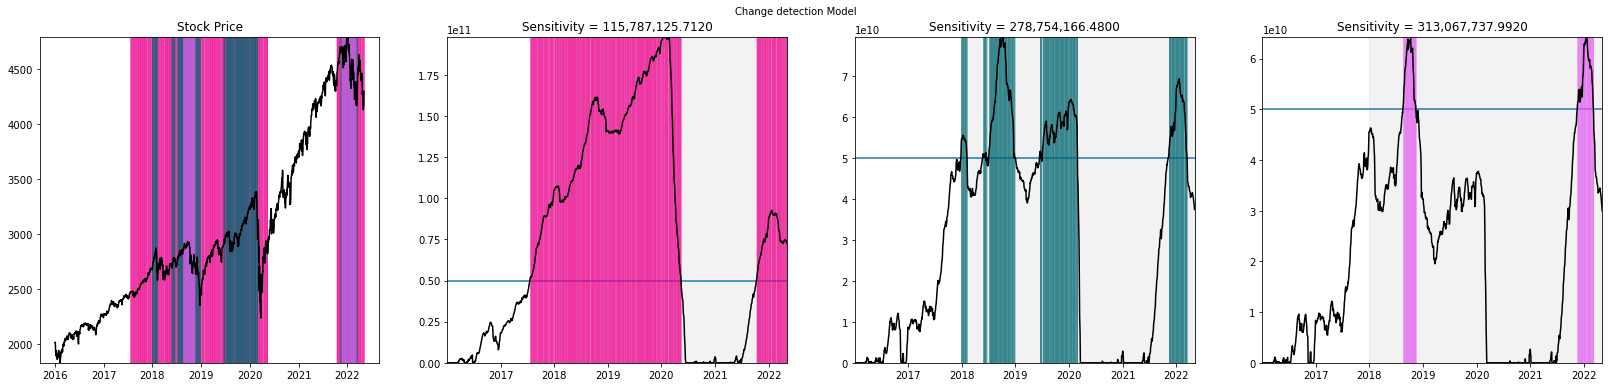

In [227]:
d = stock_data['SPY']
color_list = {'red': '#ED7C6A', 'green': '01DC86','yellow': '#B4CA25'}
check_C = np.array([1.1618,2.797,3.1413]) * .09966184e9
thresh = .5e11

cDmodel_plot(d['2016-01-01':'2022-05-04'], check_C, thresh,column = 'Volume' ,dir ='decrease', scale = False)

> Above we manually set the sensitivity and threshold of the model. However in real world practice this is a bit suboptimal, We want to be able to determine what values 
would make a decent senstivitiy and threshold that would satisify our needs. 

### Optimizing for parameters $C \& T$
We could begin by finding the minimum sensitivity value that will actually find changes in the function

In [249]:
def chgDetector2(d, sensitivity = 1, threshold = 1, direction= 'both', scale = True):
    from pandas import DataFrame
    import numpy as np 
    """   *****Returns: number of hits (int), C_t parameter (pd.df)*****
     X = dataframe perferably a 1d series, or array, datetime index is allowed. 
    Input aggregated data for better result. The algorithim will look 
    for changes given a sensitivity and threshold level. """
    def normalize_vector(data):
        return np.array((data - np.min(data)) / (np.max(data) - np.min(data)))
    if scale != True:
        x_i = d.to_numpy()
    else: 
        x_i = normalize_vector(d)

    hits = 0 
    while hits < 10:
        mu = np.mean(x_i)

        if direction.lower() == 'up':
            x_mu_c = (x_i - mu - sensitivity)
            x_mu_c[0,] = 0
        if direction.lower() == 'down':
            x_mu_c = (mu - x_i - sensitivity)
            x_mu_c[0,] = 0
        if direction.lower() == 'both':
            x_mu_c = abs(x_i - mu) - sensitivity
            x_mu_c[0,] = 0
        
        s_t = np.zeros(x_mu_c.shape)

        for i in range(1, x_mu_c.shape[0]):
            s_t[i] = max(0, (s_t[(i-1)] + x_mu_c[i]))
        
        t = 1.0*(s_t > threshold)
        out = DataFrame(np.array([x_mu_c, s_t, t]).T,columns= ['X_MU_C', 'S_T', 'Threshold_trigger'], index=d.index).round(4)
        out['Sensitivity'] = sensitivity
        hits = len(out[out['Threshold_trigger']==1])
        if hits < 20:
            break
        else: 
            sensitivity * 10
    return hits, out 

In [260]:
d = stock_data['SPY']['Volume']['2000-05-01':'2010-10-01']
# Iterate over 100,000 values of sensitivity 
chgDetector2(d, .21991, 1, 'both')


(532,
             X_MU_C      S_T  Threshold_trigger  Sensitivity
 Date                                                       
 2000-05-01  0.0000   0.0000                0.0      0.21991
 2000-05-02 -0.0700   0.0000                0.0      0.21991
 2000-05-03 -0.0682   0.0000                0.0      0.21991
 2000-05-04 -0.0622   0.0000                0.0      0.21991
 2000-05-05 -0.0514   0.0000                0.0      0.21991
 ...            ...      ...                ...          ...
 2010-09-27 -0.1377  13.8500                1.0      0.21991
 2010-09-28 -0.0983  13.7517                1.0      0.21991
 2010-09-29 -0.1015  13.6502                1.0      0.21991
 2010-09-30 -0.0750  13.5752                1.0      0.21991
 2010-10-01 -0.0737  13.5015                1.0      0.21991
 
 [2622 rows x 4 columns])

In [264]:
d.head(50).to_csv('sample.csv')

# Taking the approach online: 
The changefinder package uses sequentially discounting autoregression time series modeling (SDAR) for short. Its an extension to Autoregressive modeling, where older data points are essentially discounted. That is more importance is focused on the current values rather than the older ones. 


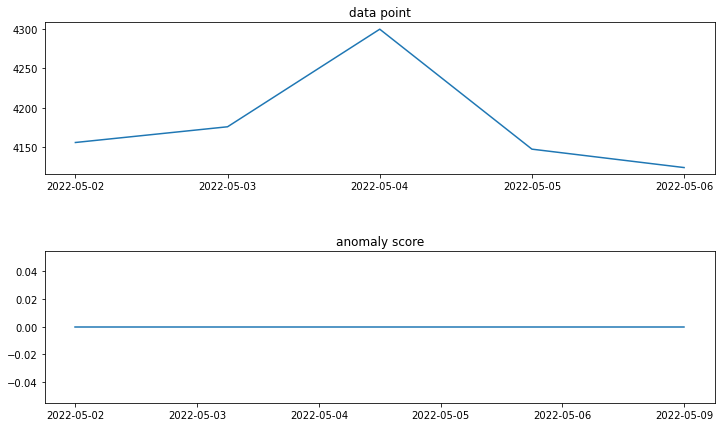

In [101]:
import changefinder 
cf = changefinder.ChangeFinder()
scores = [cf.update(p) for p in d]
scores = pd.Series(scores, index = d.index)

#CHANGEFINDER PACKAGE
f, (ax1, ax2) = plt.subplots(2, 1, figsize = (12, 7))
f.subplots_adjust(hspace=0.5)
d = stock_data['SPY']['Close']['2022-05-01':]
ax1.plot(d)
ax1.set_title("data point")
ax2.plot(scores)
ax2.set_title("anomaly score")
plt.show() 
fig.autofmt_xdate()